<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT19/blob/maxbergmark/Lab-6/maxbergmark_lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Partial differential equations**
**Max Bergmark**

# **Abstract**

In this lab, I investigate FEM methods for solving 1D and 2D Poisson equations.

#**About the code**

I am the author of the code in its entirety.

# **Set up environment**

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

In this lab, I use regular grids in 1D and 2D. However, the algorithms I have designed are capable of handling non-regular grids both in 1D and 2D. The reason for using regular grids is that verification of solutions is easier, and fabricating differential equations that satisfy the boundary conditions becomes easier. 

# **Methods**

In [0]:
def gauss_quad_2D(f, x):
    p0x, p0y = (x[0] + x[1])/2
    p1x, p1y = (x[1] + x[2])/2
    p2x, p2y = (x[2] + x[0])/2
    return (f(p0x, p0y) + f(p1x, p1y) + f(p2x, p2y)) / 3

## 1: FEM for 1D boundary value problem $-u''(x) = f(x), u(0)=u(1)=0$

For this task, I used the equation $\sum_{j=1}^M U(x_j) \int_0^1 \phi'_j(x) \phi'_i(x)dx = \int_0^1 f(x) \phi_i(x)dx, i = 1, ..., M$, which corresponds to the matrix equation $Ax = b$. In 1D, $\phi_i(x)$ is a piecewise linear function which is zero everywhere except around the $i$th mesh point. From this, we know that $A$ is a tridiagonal matrix, and we also know that $\phi'_i(x)$ is piecewise constant. Thus, the first integral can be exactly defined as $\int_0^1 \phi'_j(x) \phi'_i(x)dx = \begin{cases} -\frac{1}{h_i}, j = i+1 \\ \frac{1}{h_{i-1}} + \frac{1}{h_i}, i = j \\ -\frac{1}{h_{i-1}}, j = i-1 \end{cases}$

We can estimate the second integral using 1-point Gauss quadrature, which is also called the midpoint rule. 

In [0]:
def fem_1D(f, x):
    m = x.size
    A = np.zeros((m, m))
    b = np.zeros(m)
    
    for i in range(0, m):
        if i > 0:
            A[i,i-1] = -1/(x[i] - x[i-1])
            A[i,i] += 1/(x[i] - x[i-1])
            b[i] += f((x[i] + x[i-1])/2) * .5 * (x[i] - x[i-1])
        if i < m-1:
            A[i,i+1] = -1/(x[i+1] - x[i])
            A[i,i] += 1/(x[i+1] - x[i])
            b[i] += f((x[i+1] + x[i])/2) * .5 * (x[i+1] - x[i])
    
    # consider boundary conditions
    A[0,:] = 0
    A[:,0] = 0
    A[-1,:] = 0
    A[:,-1] = 0
    b[0] = 0
    b[-1] = 0
    x = np.linalg.lstsq(A, b, rcond = None)[0]
    return x


## 2: FEM for 2D Poisson equation $-\Delta u(x) = f(x)$, with triangular mesh

For the 2D case, the algorithm is very much the same, but we need to use a data structure to keep track of which vertices are neighbors, and where the elements are. After that, we loop over all elements, and calculate the integrals in much the same way as the 1D case. The big difference is that in multiple dimensions, the gradient is used in place of the derivative. 

Instead of creating an affine transform from a reference triangle, I calculated explicit forms for all basis functions for an arbitrary triangle. From there, it was easy to evaluate both the integral of the multiplied gradients and the Gauss quadrature of the function multiplied with the basis functions. 

To scale all integrals correctly, I kept track of the area of all triangles by using the shoelace formula. I also made sure to check that the vertices were not on the boundary before calculating, since the boundary is set to 0 in my Dirichlet condition. After forming the matrix $A$ and the vector $b$, the solution is found by least square approximation. 

In [0]:
def fem_2D(f, verts, tris, bound):
    m = verts.shape[0]
    A = np.zeros((m, m))
    b = np.zeros(m)
    for tri in tris:
        vert = np.array([verts[i] for i in tri])
        x1, x2, x3 = (verts[i][0] for i in tri)
        y1, y2, y3 = (verts[i][1] for i in tri)
        div = (x1*(y3-y2) + x2*(y1-y3) + x3*(y2-y1))
        phi_1 = lambda x, y: (x*(y3-y2) + y*(x2-x3) + x3*y2 - x2*y3) / div
        phi_2 = lambda x, y: (x*(y1-y3) + y*(x3-x1) + x1*y3 - x3*y1) / div
        phi_3 = lambda x, y: (x*(y2-y1) + y*(x1-x2) + x2*y1 - x1*y2) / div
        phi_11_g = ((y3-y2)*(y3-y2) + (x2-x3)*(x2-x3))/div**2
        phi_22_g = ((y1-y3)*(y1-y3) + (x3-x1)*(x3-x1))/div**2
        phi_33_g = ((y2-y1)*(y2-y1) + (x1-x2)*(x1-x2))/div**2

        phi_12_g = ((y3-y2)*(y1-y3) + (x2-x3)*(x3-x1))/div**2
        phi_23_g = ((y1-y3)*(y2-y1) + (x3-x1)*(x1-x2))/div**2
        phi_31_g = ((y2-y1)*(y3-y2) + (x1-x2)*(x2-x3))/div**2
        phi_1f = lambda x, y: phi_1(x, y)*f(x, y)
        phi_2f = lambda x, y: phi_2(x, y)*f(x, y)
        phi_3f = lambda x, y: phi_3(x, y)*f(x, y)
        area = .5*abs((x1-x3)*(y2-y1) - (x1-x2)*(y3-y1))

        if tri[0] not in bound and tri[1] not in bound:
            A[tri[0], tri[1]] += phi_12_g * area
            A[tri[1], tri[0]] += phi_12_g * area
        if tri[1] not in bound and tri[2] not in bound:
            A[tri[1], tri[2]] += phi_23_g * area
            A[tri[2], tri[1]] += phi_23_g * area
        if tri[2] not in bound and tri[0] not in bound:
            A[tri[2], tri[0]] += phi_31_g * area
            A[tri[0], tri[2]] += phi_31_g * area
        if tri[0] not in bound:
            A[tri[0], tri[0]] += phi_11_g * area
            b[tri[0]] += gauss_quad_2D(phi_1f, vert) * area
        if tri[1] not in bound:
            A[tri[1], tri[1]] += phi_22_g * area
            b[tri[1]] += gauss_quad_2D(phi_2f, vert) * area
        if tri[2] not in bound:
            A[tri[2], tri[2]] += phi_33_g * area
            b[tri[2]] += gauss_quad_2D(phi_3f, vert) * area

    x = np.linalg.lstsq(A, b, rcond = None)[0]
    return x

def generate_fem_2D(m, n):
    verts = np.array([[i/(n-1), j/(m-1)] for j in range(m) for i in range(n)])
    tris = []
    for j in range(m-1):
        for i in range(n-1):
            tris.append([j*n+i, j*n+i+1, (j+1)*n+i])
            tris.append([(j+1)*n+i, (j+1)*n+i+1, j*n+i+1])

    bound = set()
    for j in range(m):
        bound.add(j*n)
        bound.add((j+1)*n-1)
    for i in range(n):
        bound.add(i)
        bound.add((m-1)*n+i)
    return verts, tris, bound


# **Results**

## 1: FEM for 1D boundary value problem $-u''(x) = f(x), u(0)=u(1)=0$

The results are as anticipated. We are able to see that our matrix $A$ has the value $\frac{2}{h}$ on the main diaginal (except for the first and last value due to boundary conditions), and $-\frac{1}{h}$ on both diagonals next to the main diagonal (except forr the first and last value due to boundary conditions), given that the spacing between nodes is equal. 

The reason for this form can be taken from using the definition of the derivative $ f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}$ and applying it twice to get $f''(x) = \lim_{h \to 0} \frac{f(x-h) - 2f(x) + f(x+h)}{h^2}$, which looks very similar to the rows of our matrix $A$. However, we must note that in our original problem, we have a negative sign before $u''(x)$, and in our integral we scale the vector $b$ by a factor proportinal to $h$, which in combination explains the difference between the matemathical formula and our matrix equation. 

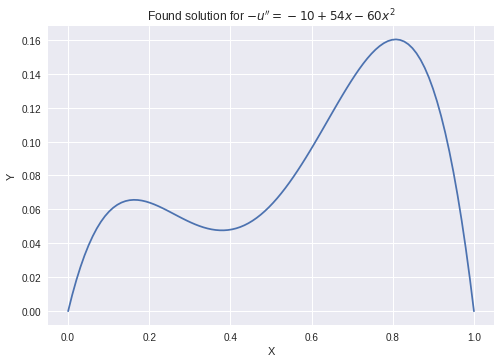

In [8]:
def show_solution_1D():
    # manufactured functions
    f = lambda x: 10 - 54*x + 60*x**2
    true_u = lambda x: x - 5*x**2 + 9*x**3 - 5*x**4

    nodes = np.linspace(0, 1, 100)
    sol = fem_1D(f, nodes)
    plt.plot(nodes, sol)
    plt.title(r"Found solution for $-u'' = -10 + 54x - 60x^2$")
    plt.ylabel("Y")
    plt.xlabel("X")
    plt.show()

show_solution_1D()

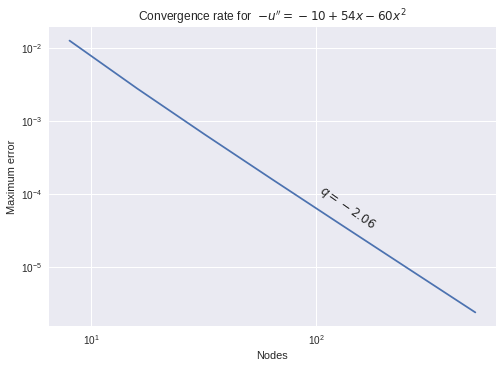

In [9]:
def test_convergence_1D():
    # manufactured functions
    f = lambda x: 10 - 54*x + 60*x**2
    true_u = lambda x: x - 5*x**2 + 9*x**3 - 5*x**4

    ns = []
    max_errs = []

    for i in range(3, 10):
        n = 2**i
        nodes = np.linspace(0, 1, n)
        sol = fem_1D(f, nodes)
        err = np.abs(sol - true_u(nodes))
        max_errs.append(err.max())
        ns.append(n)
        # plt.semilogy(nodes, err)
    conv = (np.log(max_errs[-1]) - np.log(max_errs[0]))/(np.log(ns[-1]) - np.log(ns[0]))
    plt.loglog(ns, max_errs)
    plt.text(1e2, 1e-4, "$q = %.2f$" % conv, rotation = -35)
    plt.title(r"Convergence rate for  $-u'' = -10 + 54x - 60x^2$")
    plt.ylabel("Maximum error")
    plt.xlabel("Nodes")
    plt.show()

test_convergence_1D()

## 2: FEM for 2D Poisson equation $-\Delta u(x) = f(x)$, with triangular mesh

For the 2D case, the difficulty lies in correctly identifying both neighbors and boundary conditions for each node in the mesh. However, this is largely solved by iterating over the elements rather than the nodes. 

For the example equation below, the convergence rate is 1, whereas the convergence rate above was 2. I think this is due to the fact that the Gauss quadrature used gives us a worse approximation for the specific equation compared to the 1D case. 

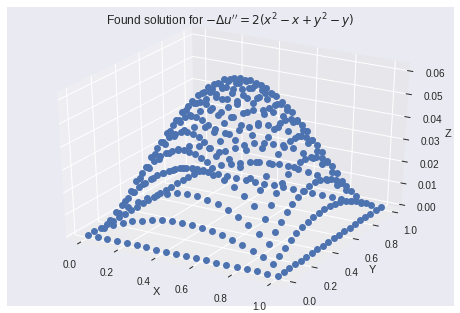

In [10]:
def show_solution_2D():
    # manufactured functions
    f = lambda x, y: -2*(x**2-x+y**2-y)
    true_u = lambda x, y: x*(1-x) * y*(1-y)

    m = 20
    n = 20
    verts, tris, bound = generate_fem_2D(m, n)
    sol = fem_2D(f, verts, tris, bound)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    # ax1 = fig.add_subplot(122)
    x = np.array([v[0] for v in verts])
    y = np.array([v[1] for v in verts])

    true_value = true_u(x, y)
    err = np.abs(sol - true_value)
    ax.plot(x, y, sol, 'o')
    plt.title(r"Found solution for $-\Delta u'' = 2(x^2-x + y^2 - y)$")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

show_solution_2D()

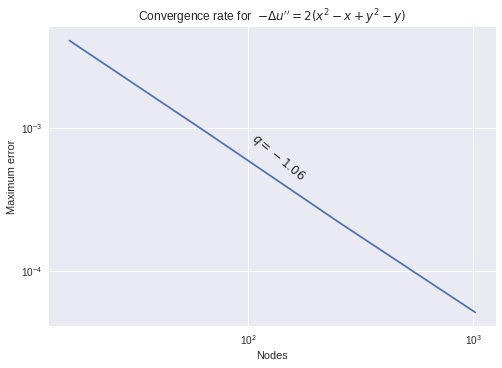

In [11]:

def test_convergence_2D():
    # manufactured functions
    f = lambda x, y: -2*(x**2-x+y**2-y)
    true_u = lambda x, y: x*(1-x) * y*(1-y)

    ns = []
    max_errs = []
    for i in range(2, 6):
        verts, tris, bound = generate_fem_2D(2**i, 2**i)
        x = np.array([v[0] for v in verts])
        y = np.array([v[1] for v in verts])
        sol = fem_2D(f, verts, tris, bound)
        errs = np.abs(sol - true_u(x, y))
        max_errs.append(errs.max())
        ns.append(2**(2*i))

    plt.loglog(ns, max_errs)
    conv = (np.log(max_errs[-1]) - np.log(max_errs[0]))/(np.log(ns[-1]) - np.log(ns[0]))
    # print(conv)
    plt.text(1e2, 8e-4, "$q = %.2f$" % conv, rotation = -40)
    plt.title(r"Convergence rate for  $-\Delta u'' = 2(x^2-x + y^2 - y)$")
    plt.ylabel("Maximum error")
    plt.xlabel("Nodes")
    plt.show()
    
test_convergence_2D()

# **Discussion**

Having done the L2 projection in Lab 4 really helped with this lab. Once the integrals were approximated, the 2D case was not as difficult as I had anticipated. However, my approach of finding explicit forms for the basis functions of an arbitrary triangle proved to be a lot of work, and perhaps not the most efficient approach. 